In [1]:
from sklearn import svm
import matplotlib.pyplot as plt
from Haldane_anis_supervise_class import *
from partial import *

In [ ]:
L = 51  # number of particles must be odd
keep = [25, 26, 27] # keep the part that we wanna do partial trace over that
bond = 50  # reasonable amount
p = partial(L, keep, bond)

In [3]:
dataset = p.generate_dataset()
partial_density_matrix_train, partial_density_matrix_test = p.partial_density_matrix()
kernel_partial_train = p.gram_train_partial(partial_train=partial_density_matrix_train)
kernel_partial_test = p.gram_test_partial(partial_train=partial_density_matrix_train, partial_test=partial_density_matrix_test)

Starting dataset generation — this step includes both the training and test sets. Please be patient...


Generating train set: 100%|██████████| 190/190 [00:14<00:00, 12.81it/s]


Train_set is generated in 15.43 seconds.


Generating test set: 100%|██████████| 1600/1600 [00:29<00:00, 53.70it/s]


Test_set is generated in 30.97 seconds.
Computing partial density matrices started .....
Tracing over training set (190 items)...


Tracing train set: 100%|██████████| 190/190 [00:00<00:00, 520.95it/s]


Tracing over test set (1600 items)...


Tracing test set: 100%|██████████| 1600/1600 [00:01<00:00, 951.66it/s]


Partial density matrices computed in 3.92 seconds.
Computing Gram matrix for training set...


Gram Partial Train: 100%|██████████| 36100/36100 [00:00<00:00, 63219.77it/s]


Gram matrix for training set computed in 0.58 seconds.
Computing Gram matrix for testing set...


Gram Partial Test: 100%|██████████| 1600/1600 [00:08<00:00, 180.38it/s]

Gram matrix for testing set computed in 8.88 seconds.


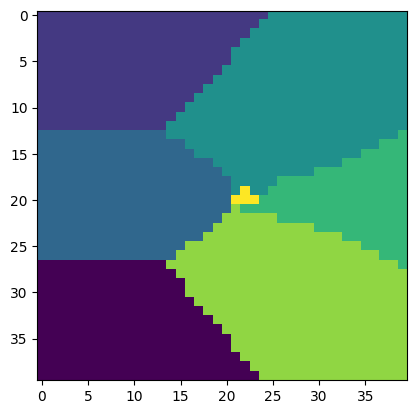

In [10]:
clf = svm.SVC(kernel='precomputed')
kernel_train = kernel_partial_train
kernel_test = kernel_partial_test
y = dataset[0][1]
clf.fit(kernel_train, y) 
y_pred = clf.predict(kernel_test)
plt.imshow(y_pred.reshape(40,40))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define ranges for E and D
E = np.arange(-2, 2, 0.1)
D = np.arange(-2, 2, 0.1)

# Lists to store points and targets
lst_points = []
lst_target = []

# Loop through E and D and classify points
for e in E:
    if 0.8 < e < 2:
        lst_points.append([-2, e])
        lst_target.append(1)  # 'large_ex'
    elif -0.8 < e < 0.8:
        lst_points.append([-2, e])
        lst_target.append(3)  # 'z_neel'
    elif -2 < e < -0.8:
        lst_points.append([-2, e])
        lst_target.append(2)  # 'large_ey'


for e in E:
    if -2 < e < -0.4:
        lst_points.append([2, e])
        lst_target.append(4)  # 'x_neel'
    elif -0.4 < e < 0.4:
        lst_points.append([2, e])
        lst_target.append(5)  # 'large_d'
    elif 0.4 < e < 2.0:
        lst_points.append([2.0, e])
        lst_target.append(6)  # 'y_neel'


for d in D:
    if -2 < d < 0.2:
        lst_points.append([d, 2])
        lst_target.append(1)  # 'large_ex'
    elif 0.2 < d < 2.0:
        lst_points.append([d, 2.0])
        lst_target.append(6)  # 'y_neel'

for d in D:
    if -2 < d < 0.2:
        lst_points.append([d, -2])
        lst_target.append(2)  # 'large_ey'
    elif 0.2 < d < 2.0:
        lst_points.append([d, -2])
        lst_target.append(4)  # 'x_neel'

for d in np.arange(-2, -0.5, 0.1):  # Added step size 0.1
    lst_points.append([d, 0.0])
    lst_target.append(3) 

for d in np.arange(0.9, 2, 0.1):
    lst_points.append([d, 0.0])
    lst_target.append(5)  # 'large_d'

for d in np.arange(-0.2, 0.6, 0.1):
    lst_points.append([d, 0.0])
    lst_target.append(7) #'Haldane'


points = np.array(lst_points)
targets = np.array(lst_target)


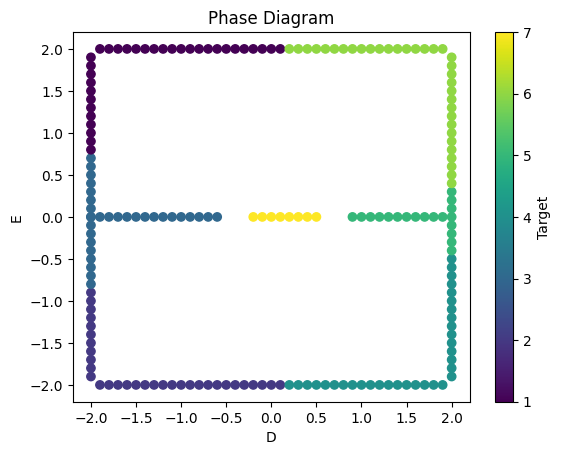

In [6]:
plt.scatter(points[:, 0], points[:, 1], c=targets)

plt.xlabel('D')
plt.ylabel('E')
plt.colorbar(label='Target')
plt.title('Phase Diagram')

plt.show()

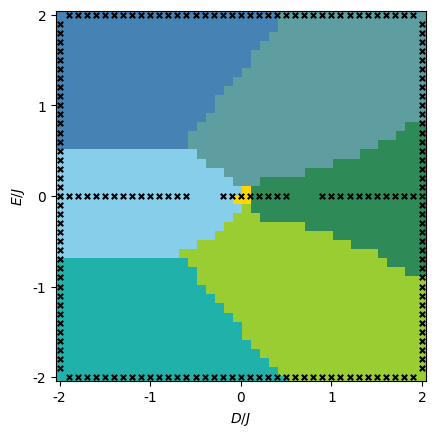

In [10]:
mat = y_pred.reshape(40,40)
r = mat.shape[0]
c = mat.shape[1]
dx = 4/r
dy = 4/c

for j in range(c):
    for i in range(r):
        if mat[j,i] == 1:
            plt.scatter((i*dx)+dx/2,(j*dy)+dy/2,marker = 's', color = 'steelblue',s=320, edgecolors='none')
        elif mat[j,i] == 2:
            plt.scatter((i*dx)+dx/2,(j*dy)+dy/2,marker = 's', color ='lightseagreen',s =320,  edgecolors='none')
        elif mat[j,i] == 3:
            plt.scatter((i*dx)+dx/2,(j*dy)+dy/2,marker = 's', color ='skyblue',s =320,  edgecolors='none')
        elif mat[j,i] == 4:
            plt.scatter((i*dx)+dx/2,(j*dy)+dy/2,marker = 's', color ='yellowgreen',s =320,  edgecolors='none')
        elif mat[j,i] == 5:
            plt.scatter((i*dx)+dx/2,(j*dy)+dy/2,marker = 's', color ='seagreen',s =320,  edgecolors='none')
        elif mat[j,i] == 6:
            plt.scatter((i*dx)+dx/2,(j*dy)+dy/2,marker = 's', color ='cadetblue',s =320,  edgecolors='none')
        elif mat[j,i] == 7:
            plt.scatter((i*dx)+dx/2,(j*dy)+dy/2,marker = 's', color ='gold',s =320,  edgecolors='none')

plt.scatter(points[:, 0]+2, points[:, 1]+2, marker='x',color='black', s=15)
plt.gca().set_aspect('equal')
plt.xlim([-0.04,4.04])
plt.ylim([-0.04,4.04])
plt.xticks([0,1,2,3,4],[-2,-1,0,1,2])
plt.yticks([0,1,2,3,4],[-2,-1,0,1,2])
plt.xlabel('$D/J$')
plt.ylabel('$E/J$')
plt.savefig('anisotropic_Haldan_svm.png')
plt.show()
